SVI, SSVI and local variance
---------
*******

In [1]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# SVI Parameterisation and absence of arbitrage

## SVI parameterisation

The SVI formula, proposed by Jim Gatheral in 2004 (see \cite{Gatheral} and \cite{GatheralJacquier}), is a parameterisation for the total implied variance, and reads as follows:
$$
SVI(x) = a+b\left\{\rho(x-m) + \sqrt{(x-m)^2 + \sigma^2}\right\},
\qquad \text{for all }x\in\mathbb{R},
$$
where $x$ represents the log-moneyness, and $a, b, \rho, m, \sigma$ are real parameters satisfying $a, b, \sigma>0$ and $\rho \in [-1,1]$.

In [6]:
def SVI(x, sviParams):
    a, b, rho, m, sigma = sviParams
    return a + b*(rho*(x-m) + np.sqrt((x-m)*(x-m) + sigma*sigma))

def SVI1(x, sviParams):
    ## First derivative with respect to x
    a, b, rho, m, sigma = sviParams
    sig2 = sigma*sigma
    return b*(rho*np.sqrt((x-m)*(x-m)+sig2)+x-m)/(np.sqrt((x-m)*(x-m)+sig2))

def SVI2(x, sviParams):
    ## Second derivative with respect to x
    a, b, rho, m, sigma = sviParams
    sig2 = sigma*sigma
    return b*sig2/(np.sqrt((x-m)*(x-m)+sig2)*((x-m)*(x-m)+sig2))

### Numerical example

In [7]:
a, b, rho, m, sigma = 0.030358, 0.0503815, -0.1, 0.3, 0.048922

sviParams = a, b, rho, m, sigma
sviParams2 = a, b, rho, m, 3.*sigma

xx = np.linspace(-1., 1., 100)

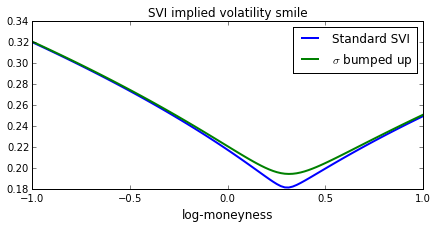

In [8]:
impliedVar = [sqrt(SVI(x, sviParams)) for x in xx]
impliedVarpp = [sqrt(SVI(x, sviParams2)) for x in xx]

plt.figure(figsize=(7,3)) # make separate figure
plt.plot(xx, impliedVar, 'b', linewidth=2, label="Standard SVI")
plt.plot(xx, impliedVarpp, 'g', linewidth=2, label="$\sigma$ bumped up")
plt.title("SVI implied volatility smile")
plt.xlabel("log-moneyness", fontsize=12)
plt.legend()
plt.show()

## Density function under SVI

Recall that, given the total implied variance at time $t$, the density of the corresponding stock price process reads
\begin{align*}
p_T(x) & = \mathrm{e}^{x}\left.\frac{\partial^2 C(K,T)}{\partial K^2}\right|_{K=S_0 \mathrm{e}^{x}}
 = \mathrm{e}^{x}\left.\frac{\partial^2 \widetilde{C}_{\mathrm{BS}}(x, \sqrt{w(x,T)})}{\partial K^2}\right|_{K=S_0 \mathrm{e}^{x}}\\
 &  = \frac{g(x,T)}{\sqrt{2\pi w(x,T)}}\exp\left(-\frac{d_-(x, w(x,T))^2}{2}\right)
\end{align*}
where
\begin{equation}\label{gFunction}
\left.
g(x,T):=\left(\left(1-\frac{x\partial_x w}{w}\right)^2 -\frac{(\partial_x w)^2}{4}\left(\frac{1}{4}+\frac{1}{w}\right) + \frac{\partial_{xx}w}{2}\right)
\right|_{(x,T)}.
\end{equation}

In [9]:
from math import pi
def g(x, sviParams):
    w = SVI(x, sviParams)
    w1 = SVI1(x, sviParams)
    w2 = SVI2(x, sviParams)
    return (1.-0.5*x*w1/w)*(1.0-0.5*x*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
    
def dminus(x, sviParams):
    vsqrt = np.sqrt(SVI(x, sviParams))
    return -x/vsqrt - 0.5*vsqrt
    
def densitySVI(x, sviParams):
    dm = dminus(x, sviParams)
    return g(x, sviParams)*np.exp(-0.5*dm*dm)/np.sqrt(2.*np.pi*SVI(x, sviParams))

## Numerics

In [12]:
def plotDensityandSmile(sviParams, nbPoints, xmin, xmax):
    xx = linspace(xmin, xmax, nbPoints)
    zeroLine = linspace(0., 0., nbPoints)
    densityPlot = [densitySVI(x, sviParams) for x in xx]
    
    plt.figure(figsize=(10,5)) # make separate figure
    
    plt.rcParams["figure.figsize"] = [12, 10]
    plt.subplot(2, 2, 1)   # creates the first plot on 2 by 2 table
    plt.plot(xx, densityPlot, 'b', linewidth = 2)
    plt.plot(xx, zeroLine, 'k', linewidth = 2)
    plt.title('SVI implied density')
    plt.xlabel(u'log-moneyness', fontsize=15)
    fill_between(xx, densityPlot, zeroLine, where=densityPlot<zeroLine, facecolor='yellow', interpolate=True)
    
    print "Check that the density integrates to unity: ", quad(lambda x: densitySVI(x, sviParams), -20., 20., epsrel=1.49e-15, limit=200)[0]
    impliedVar = [SVI(x, sviParams) for x in xx]
    plt.subplot(2, 2, 2)   # creates the first plot on 2 by 2 table
    plt.plot(xx, impliedVar, 'b', linewidth = 2)
    plt.title('SVI implied variance smile')
    plt.xlabel(u'log-moneyness', fontsize=15)
    plt.show()

### No arbitrage (positive density)

Check that the density integrates to unity:  0.999919705046


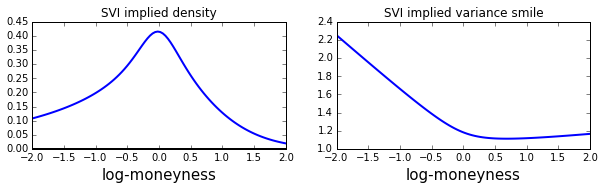

In [14]:
xmin, xmax, nbPoints = -2., 2., 100
sviParams = 1.0073, 0.3401026, -0.8, 0.000830, 0.5109564
plotDensityandSmile(sviParams, nbPoints, xmin, xmax)

### Arbitrage (the density becomes negative)

Check that the density integrates to unity:  0.852190451426


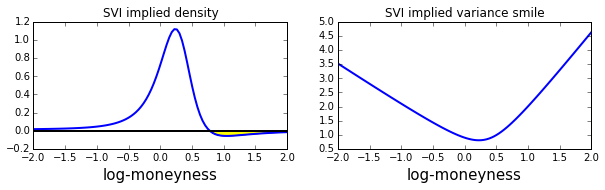

In [15]:
sviParams2 = -0.041, 2.1331, 0.306, 0.3586, 0.4153
xmin, xmax, nbPoints = -2., 2., 100
plotDensityandSmile(sviParams2, nbPoints, xmin, xmax)

# Surface SVI and equivalent local volatility

We consider the following SSVI parameterisation of the total implied variance surface:
$$
w(k,\theta_t)
= \frac{\theta_t}{2}\left\{1+\rho\varphi(\theta_t) k + \sqrt{\left(\varphi(\theta_t){k}+\rho\right)^2
+1-\rho^2 }\right\},
$$
with $\theta_t \equiv \sigma^2 t$ and 
$$
\varphi(\theta)\equiv\frac{1}{\gamma\theta}\left\{1-\frac{1-\mathrm{e}^{-\gamma\theta}}{\gamma\theta}\right\},
$$
where $\gamma>0$, $\rho \in (-1,1)$.
We further need to impose $\gamma \geq \frac{1}{4}\left(1+|\rho|\right)$ in order to prevent arbitrage.

We then compute the (Dupire) local variance via the following formula:
$$
\sigma_{\mathrm{loc}}^2(x, T) := \frac{\partial_{t}w(k, \theta_{t})}{g(k, w(k, \theta_{t}))},
$$
for all $x\in\mathbb{R}$ and $t\geq 0$, where the function $g$ is fined in (\ref{gFunction}).

In [16]:
def phi(theta, gamma):
    return 1./(gamma*theta)*(1.-(1.-np.exp(-gamma*theta))/(gamma*theta))

def SSVI(x, gamma, sigma, rho, t):
    theta = sigma*sigma*t
    p = phi(theta, gamma)
    return 0.5*theta*(1.+rho*p*x+np.sqrt((p*x+rho)*(p*x+rho)+1.-rho*rho))

def SSVI1(x, gamma, sigma, rho, t):
    ## First derivative with respect to x
    theta = sigma*sigma*t
    p = phi(theta, gamma)
    return 0.5*theta*p*(p*x+rho*np.sqrt(p*p*x*x+2.*p*rho*x+1.)+rho)/np.sqrt(p*p*x*x+2.*p*rho*x+1.)

def SSVI2(x, gamma, sigma, rho, t):
    ## Second derivative with respect to x
    theta = sigma*sigma*t
    p = phi(theta, gamma)
    return 0.5*theta*p*p*(1.-rho*rho)/ ((p*p*x*x + 2.*p*rho*x + 1.)*np.sqrt(p*p*x*x+2.*p*rho*x+1.))
    
def SSVIt(x, gamma, sigma, rho, t):
    ## First derivative with respect to t, by central difference
    eps = 0.0001
    return (SSVI(x, gamma, sigma, rho, t+eps) - SSVI(x, gamma, sigma, rho, t-eps))/(2.*eps)

def g(x, gamma, sigma, rho, t):
    w = SSVI(x, gamma, sigma, rho, t)
    w1 = SSVI1(x, gamma, sigma, rho, t)
    w2 = SSVI2(x, gamma, sigma, rho, t)
    return (1.-0.5*x*w1/w)*(1.-0.5*x*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
    
def dminus(x, gamma, sigma, rho, t):
    vsqrt = np.sqrt(SSVI(x, gamma, sigma, rho, t))
    return -x/vsqrt - 0.5*vsqrt
    
def densitySSVI(x, gamma, sigma, rho, t):
    dm = dminus(x, gamma, sigma, rho, t)
    return g(x, gamma, sigma, rho, t)*np.exp(-0.5*dm*dm)/np.sqrt(2.*np.pi*SSVI(x, gamma, sigma, rho, t))

def SSVI_LocalVarg(x, gamma, sigma, rho, t):
    ## Compute the equivalent SSVI local variance
    return SSVIt(x, gamma, sigma, rho, t) / g(x, gamma, sigma, rho, t)

## Numerical example of a SSVI local volatility surface

#### Printing some values

In [20]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import cnames
import pandas

sigma, gamma, rho = 0.2, 0.8, -0.7
t = 0.1
xx, TT = np.linspace(-1., 1., 50), np.linspace(0.001, 5., 50)

print "Consistency check to avoid static arbitrage: ", (gamma - 0.25*(1.+np.abs(rho))>0.)

localVarianceSSVI = [[SSVI_LocalVarg(x, gamma, sigma, rho, t) for x in xx] for t in TT]

Consistency check to avoid static arbitrage:  True


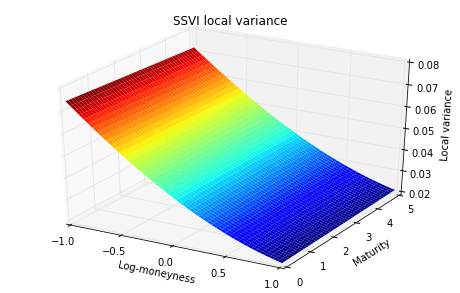

In [21]:
fig = plt.figure(figsize=(8,5))
ax = fig.gca(projection='3d')
xxx, TTT = np.meshgrid(xx, TT)
ax.plot_surface(xxx, TTT, localVarianceSSVI, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Maturity")
ax.set_zlabel("Local variance")
ax.set_title("SSVI local variance")
show()

## Monte Carlo simulations

In [22]:
from scipy import random
from numpy import maximum, mean

def price_MC_LocalVol(s0, strike, T, gamma, sigma, rho, nbSimul, nbSteps):
    deltaT = T / (1.*nbSteps)
    SS = np.linspace(s0, s0, nbSimul)
    time = np.linspace(deltaT, T, nbSteps)

    for t in time:
        sig = np.sqrt(SSVI_LocalVarg(np.log(SS), gamma, sigma, rho, t))
        SS = SS*np.exp(-0.5*sig*sig*deltaT + np.sqrt(deltaT)*sig*random.normal(0., 1., nbSimul))
    price = mean(maximum(SS - strike, 0.))
    return price

### Numerical example

In [23]:
from zanadu.Groups.ImperialCollege.Root.Tools.BlackScholes import BlackScholesCore
from zanadu.Groups.ImperialCollege.Root.Tools.ImpliedVolLeeLi import impliedVolCore

Invoking import hook for zanadu.groups.imperialcollege.root.tools.blackscholes...
blackscholes imported.
Invoking import hook for zanadu.groups.imperialcollege.root.tools.impliedvolleeli...
impliedvolleeli imported.


In [ ]:
sigma, gamma, rho = 0.2, 0.8, -0.7
s0, x, T = 1., 0., 1.
nbSimul, nbSteps = 100000, 2000
xx = np.linspace(-0.5, 0.5, 10)

print "Consistency check for no-arbitrage: ", (gamma - 0.25*(1.+np.abs(rho))>0.)

ssvivol = sqrt(SSVI(x, gamma, sigma, rho, T)/T)
BSPrice = BlackScholesCore(True,1.,s0,s0*np.exp(x),T,ssvivol)
print "BS implied vol: ", impliedVolCore(True, 1., s0, s0*np.exp(x), T, BSPrice, tolerance=1e-6, itermax=100)
print "SSVI implied vol: ", ssvivol

price = price_MC_LocalVol(s0, s0*np.exp(x), T, gamma, sigma, rho, nbSimul, nbSteps)
print "Dupire implied vol: ",  impliedVolCore(True, 1., s0, s0*np.exp(x), T, price, tolerance=1e-6, itermax=100)

\begin{bibliography}
@article{Gatheral,
  author = {Jim Gatheral},
  title = {A parsimonious arbitrage-free implied volatility parameterization with application to the valuation of volatility derivatives},
  journal = {Global Derivatives, Madrid},
  year = {2004},
  link = {http://faculty.baruch.cuny.edu/jgatheral/madrid2004.pdf},
}
@article{GatheralJacquier,
  author = {Jim Gatheral and Antoine Jacquier},
  title = { Arbitrage-free SVI volatility surfaces},
  journal = {Quantitative Finance},
  year = {2014},
  volume = {14(1)},
  pages = {59-71}
}
\end{bibliography}